# NLP2 Semster Project

## Group Members

 - Neeraj Kumar(19756303)
 - Mariann Burk ( )

# Problem Statement : Concurrent Learning of Semantic Relations
To understand whether learning a classifier for one semantic relation (e.g. hypernymy) can gain from concurrently learning another classifier for a cognitively-linked semantic relation (e.g. co-hyponymy). 

## Multi Task Problem
As we want to concurrently learn multiple semantic relationships like hypernomy/Synonyms, we will use multitask classification with hard parameter sharing. Our hypothesis is is that if the tasks are cognitively linked, multi-task learning approaches should improve the performance on the tasks as the decision functions are learned concurrently. We propose a hard parameter sharing architecture based on a feed-forward neural network
(NN) to perform the classification task.
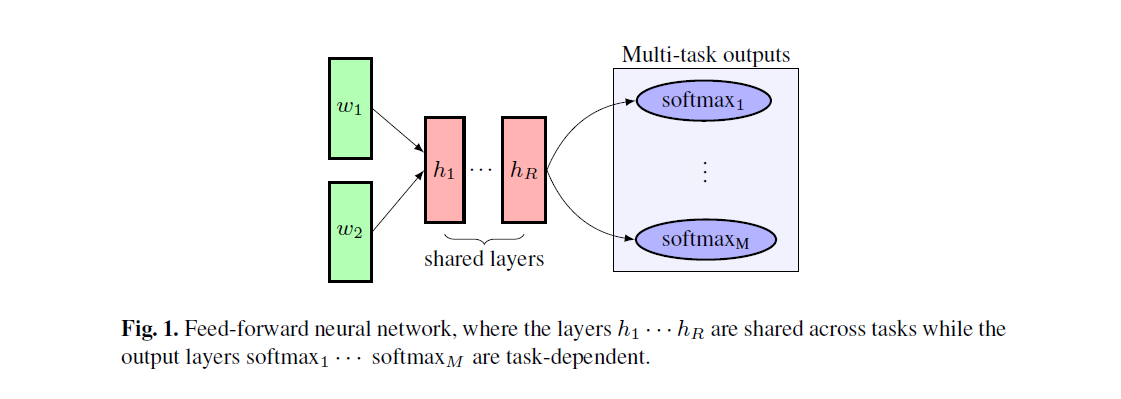

## Our Contribution
 - Compare classification performance of semantic relations among various models like logistic regression, mlp , cnn
 - Show that multi-task learning consistently improves the classification performance of semantic relations.
 - we show that semi-supervised learning can benefit performance depending on the used dataset and semantic relation.
 

# Improrting Libraries

In [1]:
from numpy.random import seed
seed(1)
import tensorflow as tf
tf.random.set_seed(2)
import numpy as np, pandas as pd
from collections import Counter
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
import matplotlib.pyplot as plt
%matplotlib inline
from keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.dummy import DummyClassifier
from sklearn.utils import shuffle


from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.models import Model
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

from keras.layers import Conv1D, Conv2D,Conv3D, MaxPooling1D, Flatten, Dense, Dropout, InputLayer, Flatten
from keras.models import Sequential
from keras import optimizers

import copy

Using TensorFlow backend.


# 1.1 Brief Description of Dataset

## Rumen Dataset 
Rumen Dataset contains 18,978 noun pairs automatically gathered fromWordNet 3.010 [24] and equally organized amongst three classes (hypernymy, synonymy and random). Note that the words in the pairs are single words and do not contain multiword expressions. In particular, the RUMEN dataset contains 9,125 word types (i.e. unique nouns) distributed as follows for each semantic relation: 5,054 for hypernymy,
5,201 for synonymy and 6,042 for random.

## Roots Dataset
Roots dataset contains 9,600 word pairs, randomly extracted from three well-known datasets: EVALution [33], Lenci/Benotto [5] and BLESS [4]. The word pairs are equally distributed among three classes (hypernymy, co-hyponymy and random) and involve several part-of-speech tags (adjectives, nouns and verbs). Here, we exclusively focus on nouns and keep 1,212 hypernyms, 1,604 co-hyponyms and 549 random pairs that can be represented by GloVe
embeddings

## 1.2 Read the data and perform data pre-processing
 - Read the word pairs corresponding to hypernyms, synonym and random relations
 - df contains the word pairs with synonym relationship
 - df2 contains the word pairs with hypernym relationship 
 - df3 contains the random word pairs with no semantic relationship

In [2]:
#This Function loads the dataset and returns 3 dataframes df1 for pairs of task1,df2 for task2 and df3 for random pairs
def three_data(name_data):
    #Perpare_data for BLess or Root9
    Rumen,Root9,Bless,Cogalex,Weeds=False,False,False,False,False
    if name_data=='Rumen':
        Rumen=True
    if name_data=='Root9':
        Root9=True
         
    def prep_df(df):
        cols =df.columns
        for i in range(len(cols)) :
            for j in range(len(df)):
                df[df.columns[i]].values[j]=df[df.columns[i]].values[j][0:-2]
        return df
    
    if Rumen :
        task1="HYPER"
        task2="SYN"
        link = "./dataset/RUMEN/RumenPairs.txt"
    if Root9 :
        link_hyper="./dataset/ROOT9/ROOT9_hyper.txt"
        link_coord="./dataset/ROOT9/ROOT9_coord.txt"
        link_random="./dataset/ROOT9/ROOT9_random.txt"
        task1= "HYPER"
        task2= "COORD"
   
    def get_names(cat):
        if cat == 0 : return "RANDOM"
        if cat == 1: return task1
        if cat == 2: return task2

    if Rumen :
        dff = pd.read_csv(link)
        dff.rename(columns={"W1":"w1", "W2":"w2","rel":"Category"}, inplace=True)
        dff["Category"] = dff["Category"].apply(get_names)
        df = dff.loc[dff.Category == task2]
        df2 = dff.loc[dff.Category == task1]
        df3 = dff.loc[dff.Category == "RANDOM"]
        print(len(df),len(df2),len(df3))
        
    if Root9 or Bless:

        df = pd.read_csv(link_coord,header=None,sep = '\t')
        df.rename(index=str,columns={0:"w1", 2:"w2",1:"Category"},inplace=True)
        df=prep_df(df)
        df2 = pd.read_csv(link_hyper,header=None,sep = '\t')
        df2.rename(index=str,columns={0:"w1", 2:"w2",1:"Category"},inplace=True)
        df2=prep_df(df2)
        df3 = pd.read_csv(link_random,header=None,sep = '\t')
        df3.rename(index=str,columns={0:"w1", 2:"w2",1:"Category"},inplace=True)
        df3=prep_df(df3)       
        
    return df,df2,df3

In [3]:
name_data='Rumen'
df,df2,df3=three_data(name_data)

6326 6326 6326


In [4]:
df

,w1,w2,Category
0,whole,unit,SYN
1,organism,being,SYN
2,act,deed,SYN
3,procedure,process,SYN
4,operation,surgery,SYN
...,...,...,...
6321,breach,severance,SYN
6322,breach,rift,SYN
6323,break,severance,SYN
6324,break,rift,SYN


### Get Corpus word list 
Get word list corresponding to hypernyms, synonyms and random words. Since we are using glove embedding, we need to make sure that our corpus is a subset of glove word list.

In [5]:
words_coord = list(set(df.w1.values.tolist() + df.w2.values.tolist()))
words_hyper = list(set(df2.w1.values.tolist() + df2.w2.values.tolist()))
words_rando = list(set(df3.w1.values.tolist() + df3.w2.values.tolist()))

### Load Glove Word Embedding. 
 - Flag each word-pair in corpus to indicate whether the corresponding two words are also a part of Glove Word list or not. 
 - This Flag will be used in data cleaning to discard word pairs, for which either of the word in word pair, does not exist in glove embedding. 

In [6]:
# load embeddings and mark the words that are in the embeddings dictionary

def get_vector_representation_of_word_pairs(dataframe, embeddings_voca):
    x1 = [embeddings_voca[word] for word in dataframe.w1.values]
    x2 =[embeddings_voca[word] for word in dataframe.w2.values]
    y = dataframe.Category.values
    #Concatenation
    x = np.hstack((x1, x2))
    return x, y

def load_embeddings(path, dimension):
    f = open(path, encoding="utf8").read().splitlines()
    vectors = {}
    for i in f:
        elems = i.split()
        vectors[" ".join(elems[:-dimension])] =  np.array(elems[-dimension:]).astype(float)
    return vectors

embeddings = load_embeddings("./embeddings//glove.6B.300d.txt", 300)
df["known_words"] = df.apply(lambda l: l["w1"] in embeddings and l["w2"] in embeddings, axis =1  )
df2["known_words"] = df2.apply(lambda l: l["w1"] in embeddings and l["w2"] in embeddings, axis =1  )
df3["known_words"] = df3.apply(lambda l: l["w1"] in embeddings and l["w2"] in embeddings, axis =1  )

In [7]:
df

,w1,w2,Category,known_words
0,whole,unit,SYN,True
1,organism,being,SYN,True
2,act,deed,SYN,True
3,procedure,process,SYN,True
4,operation,surgery,SYN,True
...,...,...,...,...
6321,breach,severance,SYN,True
6322,breach,rift,SYN,True
6323,break,severance,SYN,True
6324,break,rift,SYN,True


# 1.3 Lexical Split

Using distributional representations in the context of supervised learning tends to perform lexical memorization.In this case, the model mostly learns independent properties of single terms in pairs. For instance, if the training set contains word pairs like (bike, tandem), (bike, off-roader) and (bike, velocipede) tagged as hypernyms, the algorithm may learn that bike is a prototypical hypernym and all new pairs (bike, y) may be classified as hypernyms,regardless of the relation that holds between bike and y. To overcome this situation and prevent the model from overfitting by lexical memorization, it has been suggested to to split the train and test sets such that each one contains a distinct vocabulary. This procedure is called lexical split. For our model, lexical repetition exists in the train, validation and the unlabeled subsets, but the test set is exclusive in terms of vocabulary

 -  words_coord : Set of unique words in synonyms relation dataset
 -  words_hyper : Set of unique words in hypernyms relation dataset
 -  words_rando : Set of unique words with no semantic relation
 -  words_ : set of unqiue words in complete dataset(words_coord+words_hyper+words_rando)
 -  Divide these unqiue words in train and test with 60-40 split
 -  In Each data frame, add a flag which marks whether the word pair belongs to words in train or test list

 - 

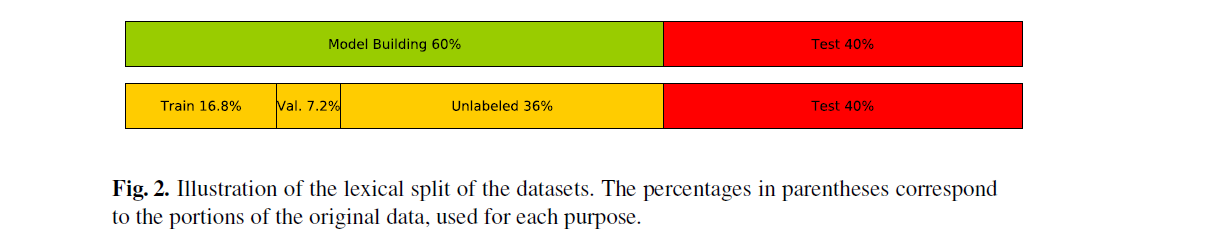

In [8]:
# Perform the lexical split using the vocabulary of the corpus

words_ = sorted(list(set(words_coord+words_hyper+words_rando)))
words_train, words_test =train_test_split(words_, test_size=0.4, random_state=1344)

# Given the words in the train and test parts, mark the pairs as training or testing, when both words of aa pair belong to the train or test vocabulary.
df["is_train"] = df.apply(lambda l : l["w1"] in words_train and l["w2"] in words_train and l["known_words"] == True, axis=1 )
df["is_test"] = df.apply(lambda l : l["w1"] in words_test and l["w2"] in words_test and l["known_words"] == True, axis=1)

df2["is_train"] = df2.apply(lambda l : l["w1"] in words_train and l["w2"] in words_train and l["known_words"] == True, axis=1 )
df2["is_test"] = df2.apply(lambda l : l["w1"] in words_test and l["w2"] in words_test and l["known_words"] == True, axis=1)

df3["is_train"] = df3.apply(lambda l : l["w1"] in words_train and l["w2"] in words_train and l["known_words"] == True, axis=1 )
df3["is_test"] = df3.apply(lambda l : l["w1"] in words_test and l["w2"] in words_test and l["known_words"] == True, axis=1)


df.shape[0], df.is_test.astype(int).sum(), df.is_train.astype(int).sum(), df.is_test.astype(int).sum() + df.is_train.astype(int).sum()

(6326, 957, 2256, 3213)

### Convert words to vector representation for each dataframe
 - Get train and test vectors for each relation( Synonyms, Hypernyms and No Relation)

In [9]:
# Prepare the inputs of the learning systems (concatenation of GloVe embeddings)
xtrainCoord, ytrainCoord = get_vector_representation_of_word_pairs(df.loc[df.is_train==True], embeddings)
xtestCoord, ytestCoord   = get_vector_representation_of_word_pairs(df.loc[df.is_test==True], embeddings)

xtrainHyper, ytrainHyper = get_vector_representation_of_word_pairs(df2.loc[df2.is_train==True], embeddings)
xtestHyper, ytestHyper   = get_vector_representation_of_word_pairs(df2.loc[df2.is_test==True], embeddings)

xtrainRando, ytrainRando = get_vector_representation_of_word_pairs(df3.loc[df3.is_train==True], embeddings) 
xtestRando, ytestRando   = get_vector_representation_of_word_pairs(df3.loc[df3.is_test==True], embeddings)

### Train Test Samples Shuffling

In [10]:
xtrainCoord.shape

(2256, 600)

In [11]:
x_train_1, x_train_2 = np.vstack((xtrainCoord, xtrainRando)), np.vstack((xtrainHyper, xtrainRando))
y_train_1, y_train_2 = [1]*len(xtrainCoord) + [0]*len(xtrainRando), [1]*len(xtrainHyper) + [0]*len(xtrainRando)


x_test_1, x_test_2 = np.vstack((xtestCoord, xtestRando)), np.vstack((xtestHyper, xtestRando))
y_test_1, y_test_2 = [1]*len(xtestCoord) + [0]*len(xtestRando), [1]*len(xtestHyper) + [0]*len(xtestRando)

x_train_1, y_train_1 = shuffle(x_train_1, y_train_1, random_state=1234)
x_train_2, y_train_2 = shuffle(x_train_2, y_train_2, random_state=1234)
x_test_1, y_test_1 = shuffle(x_test_1, y_test_1, random_state=1234)
x_test_2, y_test_2 = shuffle(x_test_2, y_test_2, random_state=1234)
assert len(x_train_1) == len(y_train_1)
assert len(x_train_2) == len(y_train_2)
assert len(x_test_1) == len(y_test_1)
assert len(x_test_2) == len(y_test_2)
print(len(x_train_1), len(x_train_2))

4483 4865


# 2 Helper Functions

## 2.1 Plotting Function 
 - Plots the validation and test performance for Synonyms and Hypernyms Classifier

In [12]:
def plotting_function(acc_scores_coord,acc_scores_hyper,mif_scores_coord,mif_scores_hyper):
    df_syn = pd.DataFrame(acc_scores_coord) 
    df_hyp = pd.DataFrame(acc_scores_hyper) 
    mif_df_syn = pd.DataFrame(mif_scores_coord) 
    mif_df_hyp = pd.DataFrame(mif_scores_hyper) 
    df_syn.rename(columns = {0: "val_acc", 1: "test_acc"}, inplace = True)
    df_hyp.rename(columns = {0: "val_acc", 1: "test_acc"}, inplace = True)
    mif_df_syn.rename(columns = {0: "val_f1_score", 1: "test_f1_score"}, inplace = True)
    mif_df_hyp.rename(columns = {0: "val_f1_score", 1: "test_f1_score"}, inplace = True)

    fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (20,10))
    axes[0][0].set_title("Accuracy Plot for Synonym Detection Task")
    df_syn.plot.line(ax = axes[0][0])
    axes[0][1].set_title("Accuracy Plot for hypernym Detection Task")
    df_hyp.plot.line(ax = axes[0][1])

    axes[1][0].set_title("F1 Score Plot for Synonym Detection Task")
    mif_df_syn.plot.line(ax = axes[1][0])
    axes[1][1].set_title("F1 Score Plot for hypernym Detection Task")
    mif_df_hyp.plot.line(ax = axes[1][1])


## 2.2 Get 10 most confident predictions from the unlabeled data set

 - This function is used for self learning algorithm
 - It takes as input the prediction of the model on unlabeled data.
 - Choose positive and nagative labels from the prediction with highest confidence
 - Add these data points to the supervised training set to be used in next iteration of training the model      
 - Challenge is to increase the supervised training set by using the most confident predictions of the classifier itself on unlabeled data

In [13]:
'''
Get get_n_most_confident_predictions from the predictions and add them to the labeled dataset. We want to use self learning to 
increase the supervised data set by using most confident predictions of the model. 
my_preds : Predictions of the model on initial unsupervised dataset. 
n : Number of samples to add to the supervised dataset. This function will take n mose confident predictions and add these to the labeled data set. 
y_train_data 
x_unlabeled : Unsupervised dataset on which the predictions has been made. 

'''

def get_n_most_confident_predictions(my_preds, n, y_train_data, x_unlabeled):
    """
    defines the function used for self-learning
    It selects 10 
    """
    y_train_data = np.array(y_train_data)
    probabilities = np.array([(y_train_data==0).sum()/y_train_data.shape[0], (y_train_data==1).sum()/y_train_data.shape[0]])
    probabilities = (probabilities * n).astype(int) 
    new_x, new_y, exclude_indices = [], [], []
    my_preds  = my_preds.reshape(1,-1)[0]
    negative_to_positive = np.argsort(my_preds)
    """
    Choose positive and nagative labels from the prediction with highest confidence. Then use these labels to in the next epoch of supervised learning
    Challenge is to increase the supervised training set by using the most confident predictions of the classifier itself on unlabeled data. 
    """
    
    new_x.extend(x_unlabeled[negative_to_positive][:probabilities[0]])
    new_x.extend(x_unlabeled[negative_to_positive][-probabilities[1]:])
    new_y.extend([0]*probabilities[0])
    new_y.extend([1]*probabilities[1])
    exclude_indices.extend(negative_to_positive[:probabilities[0]])
    exclude_indices.extend(negative_to_positive[-probabilities[1]:])
    updated_unlabel_indices = np.setdiff1d(np.arange(len(x_unlabeled)), exclude_indices)  

    return np.array(new_x), np.array(new_y), x_unlabeled[updated_unlabel_indices]

## 2.3 check_model_performance

In [14]:
# Check Model performance on test and validation data and log the values in a list 
def check_model_performance(model_coord, model_hyper,data):

    acc_scores_coord,mif_scores_coord, acc_scores_hyper,  mif_scores_hyper= [], [], [], []

    for epoch in range(100):

        history_Coord_Random = model_coord.fit(data["Coord-Random"]["x_train"], data["Coord-Random"]["y_train"], epochs=1, validation_data=None, verbose=False, )
        history_Hyper_Random = model_hyper.fit(data["Hyper-Random"]["x_train"], data["Hyper-Random"]["y_train"], epochs=1, validation_data=None, verbose=False, )
        preds_coord = (model_coord.predict(data["Coord-Random"]["x_test"], verbose=0)> 0.5).astype(int)
        preds_hyper = (model_hyper.predict(data["Hyper-Random"]["x_test"], verbose=0)> 0.5).astype(int)

        preds_coord_valid = (model_coord.predict(data["Coord-Random"]["x_valid"], verbose=0)> 0.5).astype(int)
        preds_hyper_valid = (model_hyper.predict(data["Hyper-Random"]["x_valid"], verbose=0)> 0.5).astype(int)

        acc_scores_coord.append([accuracy_score(data["Coord-Random"]["y_valid"], preds_coord_valid), accuracy_score(data["Coord-Random"]["y_test"], preds_coord)])
        acc_scores_hyper.append([accuracy_score(data["Hyper-Random"]["y_valid"], preds_hyper_valid), accuracy_score(data["Hyper-Random"]["y_test"], preds_hyper)])
        mif_scores_coord.append([f1_score(data["Coord-Random"]["y_valid"], preds_coord_valid, average="macro") , f1_score(data["Coord-Random"]["y_test"], preds_coord, average="macro")])
        mif_scores_hyper.append([f1_score(data["Hyper-Random"]["y_valid"], preds_hyper_valid, average="macro") , f1_score(data["Hyper-Random"]["y_test"], preds_hyper, average="macro")])

    return(acc_scores_coord,mif_scores_coord,acc_scores_hyper,mif_scores_hyper)



## 2.4 Check Model performance on test and validation data with Self Learning

# Semi-supervision via self-learning

Semi-supervised learning approaches perform well in a variety of tasks such as text classification and text summarization. As in the supervised learning framework, we assume that we are given access to a set L that consists of K pairs of words labeled according to the relationship rel. Complementary to that, we also assume to have access to a set of K0 words pairs U distinct from those of L, and totally unlabeled. The challenge in this setting is to surpass the perfo=rmance of classification models trained exclusively on L by using the available data in U.

 - Train Classifier C using word pairs L
 - progressively expand L, by pseudo-labeling 10 pairs within U, for which the current prediction function is the most confident and adding them to L
 
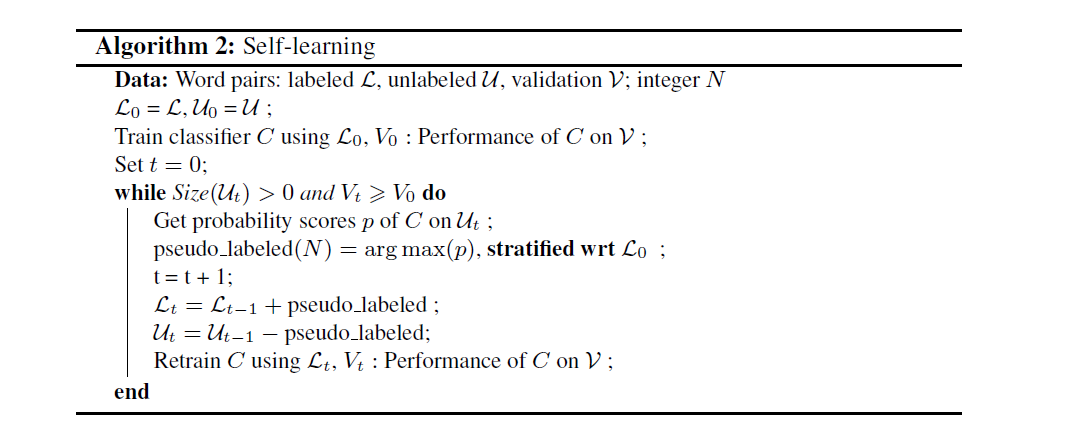

In [15]:
def check_model_performance_with_self_learning(model_coord, model_hyper,data,model_flag):
    acc_scores_coord,mif_scores_coord, acc_scores_hyper,  mif_scores_hyper= [], [], [], []
    
    for i in range(20):
        # Get model performance on unlabeled data. get_n_most_confident_predictions will take top 10 predictions and add them to the labeled set. 
        tmpx, tmpy, data["Coord-Random"]["x_unlabeled"] = get_n_most_confident_predictions(model_coord.predict(data["Coord-Random"]["x_unlabeled"]), 10, data["Coord-Random"]["y_train"], data["Coord-Random"]["x_unlabeled"])
        data["Coord-Random"]["x_train"] = np.vstack((data["Coord-Random"]["x_train"], tmpx))
        data["Coord-Random"]["y_train"] = np.concatenate((data["Coord-Random"]["y_train"], tmpy))

        tmpx, tmpy, data["Hyper-Random"]["x_unlabeled"] = get_n_most_confident_predictions(model_hyper.predict(data["Hyper-Random"]["x_unlabeled"]), 10, data["Hyper-Random"]["y_train"], data["Hyper-Random"]["x_unlabeled"])
        data["Hyper-Random"]["x_train"] = np.vstack((data["Hyper-Random"]["x_train"], tmpx))
        data["Hyper-Random"]["y_train"] = np.concatenate((data["Hyper-Random"]["y_train"], tmpy))
    
        acc_scores_coord_, mif_scores_coord_, acc_scores_hyper_,  mif_scores_hyper_ = [], [], [], []

        if(model_flag == 'mlp_nn'):
            model_coord, model_hyper = get_my_multitask_nn_models()
        elif (model_flag == 'cnn'):
            model_coord = get_my_cnn_model()
            model_hyper = get_my_cnn_model()
        elif (model_flag == 'cnn_multitask'):
            model_coord, model_hyper = get_my_multitask_cnn_models()
        else:
            return(acc_scores_coord,mif_scores_coord,acc_scores_hyper,mif_scores_hyper)
        
        # Train the model again with new supervised set. 
        acc_scores_coord_,mif_scores_coord_,acc_scores_hyper_,mif_scores_hyper_ = check_model_performance(model_coord, model_hyper,data)

        acc_scores_coord.append(max(acc_scores_coord_))
        mif_scores_coord.append(max(mif_scores_coord_))
        acc_scores_hyper.append(max(acc_scores_hyper_))
        mif_scores_hyper.append(max(mif_scores_hyper_))
    return(acc_scores_coord,mif_scores_coord,acc_scores_hyper,mif_scores_hyper)


# 3 Model Implementation
We are going to implement following Models

 - MLP with 2 layers
 - Multitask NN , First layer is shared between Synonym and Hypernym Model, where as second layer is model specific. 
 - CNN
 - Multitask CNN( Convolution layers is shared between Synonym and Hypernym Model)
 
 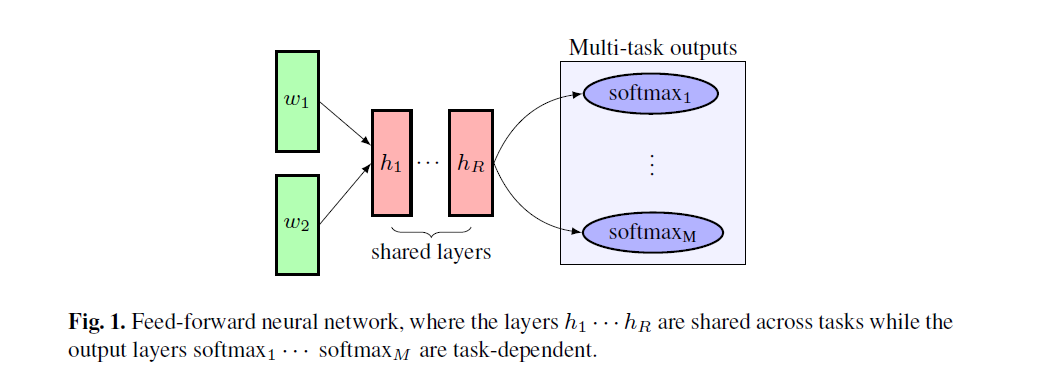

In [16]:
def get_my_nn_model():
    """Defines the NN baseline.
    Two hidden layers, followed by the output layer. 
    """
    model = Sequential()
    model.add(Dense(50, activation='sigmoid', input_dim=600))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy')
    return model

def get_my_multitask_nn_models():
    inputs = Input(shape=(600,))
    x = Dense(50, activation='sigmoid')(inputs)

    coord = Dense(1, activation='sigmoid', name='coord_output')(x)
    hyper = Dense(1, activation='sigmoid', name='hyper_output')(x)

    model_coord = Model(inputs=[inputs], outputs=[coord])
    model_hyper = Model(inputs=[inputs], outputs=[hyper])

    model_coord.compile(optimizer='rmsprop', loss='binary_crossentropy',metrics=['accuracy'])
    model_hyper.compile(optimizer='rmsprop', loss='binary_crossentropy',metrics=['accuracy'])
    return model_coord, model_hyper

def get_my_cnn_model():
    inputs = Input(shape=(1,600))
    conv = Conv1D(filters=500, kernel_size=1 ,activation='relu')(inputs)
    #conv = MaxPooling1D(2)(conv)
    conv = Conv1D(filters=500, kernel_size=1, activation='relu')(conv)
    conv = MaxPooling1D(1)(conv)
    conv = Flatten()(conv)
    conv = Dense(32, activation='relu')(conv)
    output = Dense(1, activation='sigmoid')(conv)
    
    model = Model(inputs=[inputs], outputs=[output])
    model.compile(optimizer='rmsprop', loss='binary_crossentropy',metrics=['accuracy'])
    model_hyper.compile(optimizer='rmsprop', loss='binary_crossentropy',metrics=['accuracy'])
    return model

def get_my_multitask_cnn_models():
    inputs = Input(shape=(1,600))
    conv = Conv1D(filters=500, kernel_size=1 ,activation='relu')(inputs)
    #conv = MaxPooling1D(2)(conv)
    conv = Conv1D(filters=500, kernel_size=1, activation='relu')(conv)
    conv = MaxPooling1D(1)(conv)
    conv = Flatten()(conv)
    conv = Dense(32, activation='relu')(conv)
    
    coord = Dense(1, activation='sigmoid', name='coord_output')(conv)
    hyper = Dense(1, activation='sigmoid', name='hyper_output')(conv)
    
    model_coord = Model(inputs=[inputs], outputs=[coord])
    model_hyper = Model(inputs=[inputs], outputs=[hyper])
    
    model_coord.compile(optimizer='rmsprop', loss='binary_crossentropy',metrics=['accuracy'])
    model_hyper.compile(optimizer='rmsprop', loss='binary_crossentropy',metrics=['accuracy'])
    return model_coord, model_hyper




# 4 Model Performance

## 4.1 BaseLine MLP Neural Network Performance with Self LEarning 
 - Get Logistic Regression Performance
 - Get MLP NN baseline Performance
 - Get MLP NN baseline Performance with self learning

In [17]:
data = {}
for name, x_train, y_train, x_test, y_test in zip(["Coord-Random", "Hyper-Random"], [x_train_1, x_train_2], [y_train_1, y_train_2], [x_test_1, x_test_2], [y_test_1, y_test_2]):   
    # Perform the splits in train, validation, unlabeled
    x_train, x_unlabeled, y_train, y_unlabeled = train_test_split(x_train, y_train, stratify=y_train, test_size=0.6, random_state=1234,)
    x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, stratify=y_train,  test_size=0.30, random_state=1234,)
    print("Problem", name, "\nBasic Stats:", len(x_train), len(x_valid), len(x_unlabeled), len(x_test), end=" \n")

    # Start with the accuracy and MaF1 scores of a Dummy Classifier
    clf = DummyClassifier(strategy="most_frequent")
    clf.fit(x_train, y_train)
    preds = clf.predict(x_test)
    print("Majority classifier:", accuracy_score(y_test, preds), f1_score(y_test, preds, average="macro"), end=" \n")

    
    # Logistic Regression with default params
    clf = LogisticRegression()
    clf.fit(x_train, y_train)
    preds = clf.predict(x_test)
    print("Logistic Regression:", accuracy_score(y_test, preds), f1_score(y_test, preds, average="macro"), end=" \n")
    
    if(name == "Coord-Random" ):
        lr_coord_acc = accuracy_score(y_test, preds)
        lr_coord_f1 = f1_score(y_test, preds, average="macro")
    else:
        lr_hyper_acc =  accuracy_score(y_test, preds)
        lr_hyper_f1 = f1_score(y_test, preds, average="macro")
    
    # NN baseline
    model = get_my_nn_model()
    model.fit(x_train, y_train, epochs=500, validation_data=(x_valid, y_valid), verbose=False, callbacks=[EarlyStopping(patience=5)])
    preds = model.predict_classes(x_test, verbose=False)
    print("NN baseline:", accuracy_score(y_test, preds), f1_score(y_test, preds, average="macro"), end=" \n")
    
    if(name == "Coord-Random" ):
        mlp_coord_acc = accuracy_score(y_test, preds)
        mlp_coord_f1 =  f1_score(y_test, preds, average="macro")
    else:
        mlp_hyper_acc =  accuracy_score(y_test, preds)
        mlp_hyper_f1 =   f1_score(y_test, preds, average="macro")
    
    # keep the train/validation/test splits so that hey can be used with multitask learning and the results are comparable between them
    data[name]={"x_train": x_train, "y_train":y_train, "x_unlabeled":x_unlabeled, "y_unlabeled":y_unlabeled,  "x_valid":x_unlabeled, "y_valid":y_unlabeled, "x_test":x_test,  "y_test":y_test } 
    # Save a copy of dataset
    data_org = copy.deepcopy(data)
    
    # NN baseline + self learning http://localhost:8888/notebooks/Documents/Python%20Scripts/2nd_sem/nlp2/nlp_project_1.ipynb#
    accuracy_scores, mif_scores = [], []
    for i in range(20):
        tmpx, tmpy, x_unlabeled = get_n_most_confident_predictions(model.predict(x_unlabeled), 10, y_train, x_unlabeled) # use 10 labels each time
        x_train = np.vstack((x_train, tmpx))
        y_train = np.concatenate((y_train, tmpy))
        model = get_my_nn_model()
        model.fit(x_train, y_train, epochs=500, validation_data=(x_valid, y_valid), verbose=False, \
                  callbacks=[EarlyStopping(patience=5)],)
        preds = model.predict_classes(x_test, verbose=0)
        accuracy_scores.append(accuracy_score(y_test, preds))# , f1_score(y_test, preds, average="macro"))        
        mif_scores.append( f1_score(y_test, preds, average="macro") )
    
    print("NN baseline + self-learning", max(accuracy_scores), max(mif_scores))
    if(name == "Coord-Random" ):
        mlp_self_learning_coord_acc = max(accuracy_scores)
        mlp_self_learning_coord_f1 = max(mif_scores)
    else:
        mlp_self_learning_hyper_acc = max(accuracy_scores)
        mlp_self_learning_hyper_f1 = max(mif_scores)
   



Problem Coord-Random 
Basic Stats: 1255 538 2690 1926 
Majority classifier: 0.4968847352024922 0.33194588969823097 
Logistic Regression: 0.6272066458982347 0.6272030279503107 
NN baseline: 0.6869158878504673 0.6868124622632071 
NN baseline + self-learning 0.6910695742471443 0.6910554990460482
Problem Hyper-Random 
Basic Stats: 1362 584 2919 1706 
Majority classifier: 0.4320046893317702 0.30167826442898077 
Logistic Regression: 0.7180539273153576 0.7157071532778942 
NN baseline: 0.742672919109027 0.7394753914735896 
NN baseline + self-learning 0.753810082063306 0.7508484477578725


## Multitask Training Process

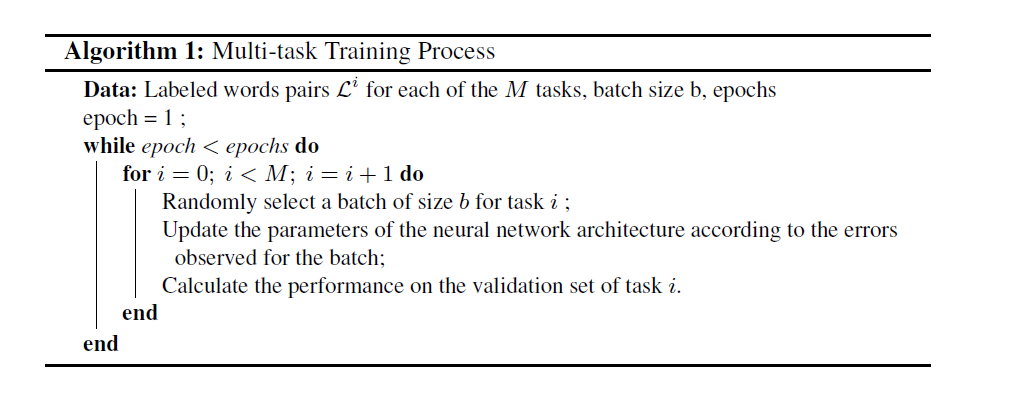

## 4.2 Multitask MLP NN Model Performance 

Multitask (Coord-Random): 0.6931464174454829 0.6931423640362784 
Multitask (Hyper-Random): 0.757327080890973 0.7537364016736402


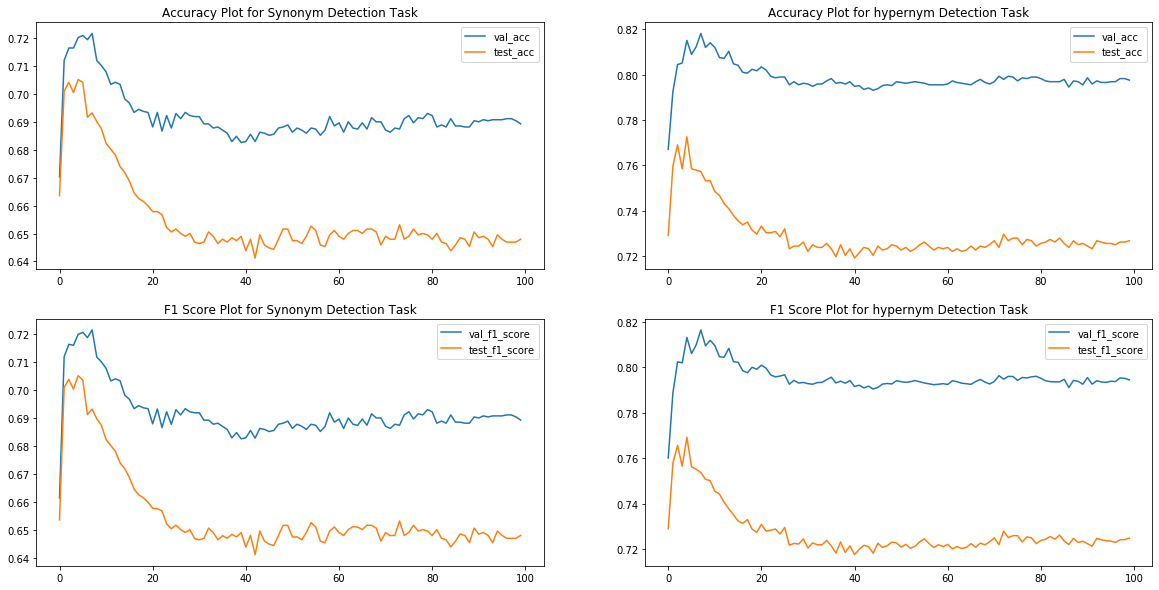

In [18]:
# Repeat the process with multi-task learning
model_coord, model_hyper = get_my_multitask_nn_models()
acc_scores_coord,mif_scores_coord,acc_scores_hyper,mif_scores_hyper = check_model_performance(model_coord, model_hyper,data)
print("Multitask (Coord-Random):", max(acc_scores_coord)[1], max(mif_scores_coord)[1], "\nMultitask (Hyper-Random):",  max(acc_scores_hyper)[1], max(mif_scores_hyper)[1])
plotting_function(acc_scores_coord,acc_scores_hyper,mif_scores_coord,mif_scores_hyper)
mlp_multitask_coord_acc = max(acc_scores_coord)[1]
mlp_multitask_hyper_acc = max(acc_scores_hyper)[1]
mlp_multitask_coord_f1 = max(mif_scores_coord)[1]
mlp_multitask_hyper_f1 = max(mif_scores_hyper)[1]

###### Accuracy and F1 score follow almost the same trajetory which shows that all the 3 classes are balanced. 

## 4.3 Multitask MLP NN Model performance with Self Learning

 - Train Classifier C using word pairs L
 - progressively expand L, by pseudo-labeling 10 pairs within U, for which the current prediction function is the most confident and adding them to L


Multitask + Self-learning(Coord-Random): 0.6988577362409139 0.6988564373251094 
Multitask + Self-learning(Hyper-Random): 0.776084407971864 0.7727056486321714


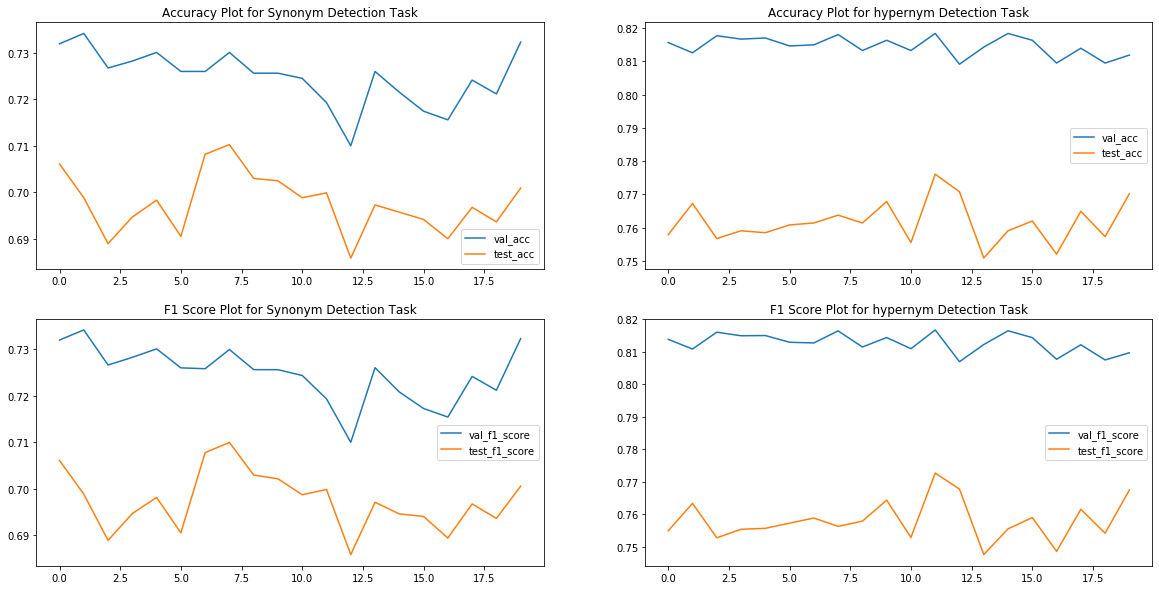

In [19]:
acc_scores_coord,mif_scores_coord,acc_scores_hyper,mif_scores_hyper = check_model_performance_with_self_learning(model_coord, model_hyper,copy.deepcopy(data),'mlp_nn')
print("\nMultitask + Self-learning(Coord-Random):", max(acc_scores_coord)[1], max(mif_scores_coord)[1], "\nMultitask + Self-learning(Hyper-Random):",  max(acc_scores_hyper)[1],  max(mif_scores_hyper)[1])
plotting_function(acc_scores_coord,acc_scores_hyper,mif_scores_coord,mif_scores_hyper)
mlp_multitask_self_learning_coord_acc = max(acc_scores_coord)[1]
mlp_multitask_self_learning_hyper_acc = max(acc_scores_hyper)[1]
mlp_multitask_self_learning_coord_f1 = max(mif_scores_coord)[1]
mlp_multitask_self_learning_hyper_f1 = max(mif_scores_hyper)[1]


## 5. CNN Model Performance

## 5.1 Change data set dimensions

In [20]:
# Change dataset dimensions 
data = copy.deepcopy(data_org)
'''
For CNN we are using Conv1D layer which requires 3 dimensional input. 
We need to reshape the training/test/validation data (data["Coord-Random"]["x_train"].shape = (1255, 600)) to the required 3 D shape.
'''

data["Coord-Random"]["x_train"] = data["Coord-Random"]["x_train"].reshape((data["Coord-Random"]["x_train"]).shape[0],1, (data["Coord-Random"]["x_train"]).shape[1])
data["Coord-Random"]["x_test"]  = data["Coord-Random"]["x_test"].reshape((data["Coord-Random"]["x_test"]).shape[0],1,   (data["Coord-Random"]["x_test"]).shape[1])
data["Coord-Random"]["x_valid"] = data["Coord-Random"]["x_valid"].reshape((data["Coord-Random"]["x_valid"]).shape[0],1, (data["Coord-Random"]["x_valid"]).shape[1])
data["Coord-Random"]["x_unlabeled"] = data["Coord-Random"]["x_unlabeled"].reshape((data["Coord-Random"]["x_unlabeled"]).shape[0],1, (data["Coord-Random"]["x_unlabeled"]).shape[1])


data["Hyper-Random"]["x_train"] = data["Hyper-Random"]["x_train"].reshape((data["Hyper-Random"]["x_train"]).shape[0],1, (data["Hyper-Random"]["x_train"]).shape[1])
data["Hyper-Random"]["x_test"]  = data["Hyper-Random"]["x_test"].reshape((data["Hyper-Random"]["x_test"]).shape[0], 1,  (data["Hyper-Random"]["x_test"]).shape[1])
data["Hyper-Random"]["x_valid"] = data["Hyper-Random"]["x_valid"].reshape((data["Hyper-Random"]["x_valid"]).shape[0],1, (data["Hyper-Random"]["x_valid"]).shape[1])
data["Hyper-Random"]["x_unlabeled"] = data["Hyper-Random"]["x_unlabeled"].reshape((data["Hyper-Random"]["x_unlabeled"]).shape[0],1, (data["Hyper-Random"]["x_unlabeled"]).shape[1])

## 5.2 Check CNN Model Performance

In [21]:
acc_scores_coord,mif_scores_coord, acc_scores_hyper,  mif_scores_hyper= [], [], [], []
model_coord = get_my_cnn_model()
model_hyper = get_my_cnn_model()

acc_scores_coord,mif_scores_coord,acc_scores_hyper,mif_scores_hyper = check_model_performance(model_coord, model_hyper,data)
print("CNN (Coord-Random):", max(acc_scores_coord)[1], max(mif_scores_coord)[1], "\nCNN (Hyper-Random):",  max(acc_scores_hyper)[1], max(mif_scores_hyper)[1])

cnn_coord_acc = max(acc_scores_coord)[1]
cnn_hyper_acc = max(acc_scores_hyper)[1]
cnn_coord_f1 = max(mif_scores_coord)[1]
cnn_hyper_f1 = max(mif_scores_hyper)[1]

acc_scores_coord,mif_scores_coord,acc_scores_hyper,mif_scores_hyper = check_model_performance_with_self_learning(model_coord, model_hyper,copy.deepcopy(data),'cnn')
print("\nCNN + Self-learning(Coord-Random):", max(acc_scores_coord)[1], max(mif_scores_coord)[1], "\nCNN + Self-learning(Hyper-Random):",  max(acc_scores_hyper)[1],  max(mif_scores_hyper)[1])

cnn_self_learning_coord_acc = max(acc_scores_coord)[1]
cnn_self_learning_hyper_acc = max(acc_scores_hyper)[1]
cnn_self_learning_coord_f1 = max(mif_scores_coord)[1]
cnn_self_learning_hyper_f1 = max(mif_scores_hyper)[1]


CNN (Coord-Random): 0.729491173416407 0.7291634221658538 
CNN (Hyper-Random): 0.7532239155920282 0.7446323157362118

CNN + Self-learning(Coord-Random): 0.731048805815161 0.7308953001596823 
CNN + Self-learning(Hyper-Random): 0.7438452520515827 0.7375117552886035


## 5.3 Check Multitask CNN Model Performance

CNN Multitask (Coord-Random): 0.7388369678089304 0.7387298389543563 
CNN Multitask (Hyper-Random): 0.7719812426729191 0.7677225834113559

CNN Multitask + Self-learning(Coord-Random): 0.7341640706126688 0.733954933954934 
CNN Multitask + Self-learning(Hyper-Random): 0.7690504103165299 0.7643077950202534


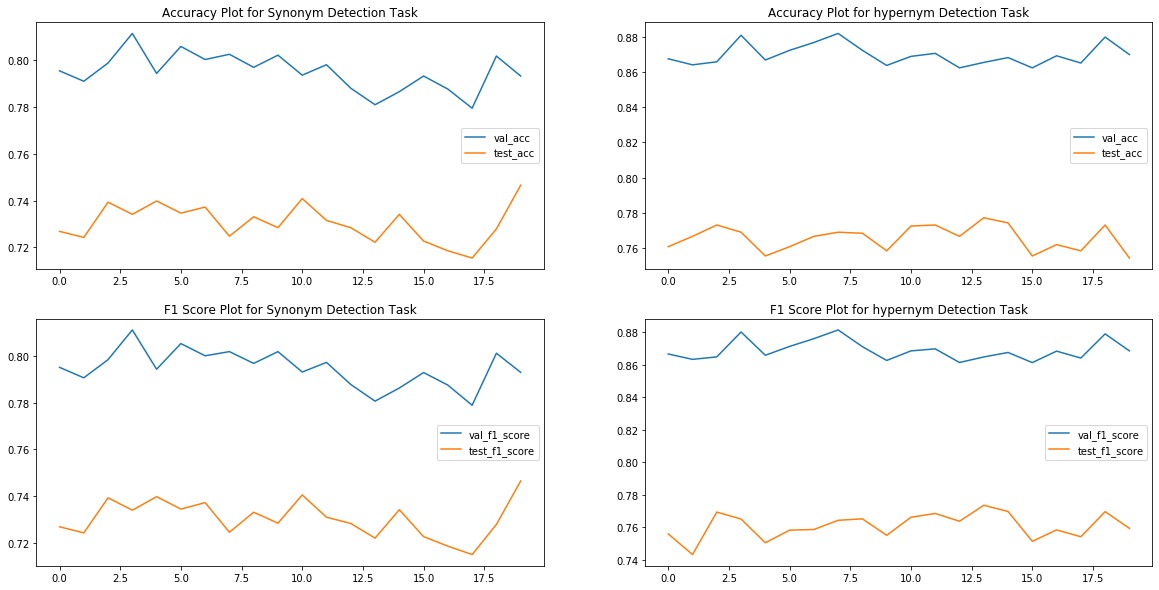

In [22]:
acc_scores_coord,mif_scores_coord, acc_scores_hyper,  mif_scores_hyper= [], [], [], []
model_coord,model_hyper = get_my_multitask_cnn_models()

acc_scores_coord,mif_scores_coord,acc_scores_hyper,mif_scores_hyper = check_model_performance(model_coord, model_hyper,data)
print("CNN Multitask (Coord-Random):", max(acc_scores_coord)[1], max(mif_scores_coord)[1], "\nCNN Multitask (Hyper-Random):",  max(acc_scores_hyper)[1], max(mif_scores_hyper)[1])

cnn_multitask_coord_acc = max(acc_scores_coord)[1]
cnn_multitask_hyper_acc = max(acc_scores_hyper)[1]
cnn_multitask_coord_f1 = max(mif_scores_coord)[1]
cnn_multitask_hyper_f1 = max(mif_scores_hyper)[1]

acc_scores_coord,mif_scores_coord,acc_scores_hyper,mif_scores_hyper = check_model_performance_with_self_learning(model_coord, model_hyper,copy.deepcopy(data),'cnn_multitask')
print("\nCNN Multitask + Self-learning(Coord-Random):", max(acc_scores_coord)[1], max(mif_scores_coord)[1], "\nCNN Multitask + Self-learning(Hyper-Random):",  max(acc_scores_hyper)[1],  max(mif_scores_hyper)[1])
plotting_function(acc_scores_coord,acc_scores_hyper,mif_scores_coord,mif_scores_hyper)
cnn_multitask_self_learning_coord_acc = max(acc_scores_coord)[1]
cnn_multitask_self_learning_hyper_acc = max(acc_scores_hyper)[1]
cnn_multitask_self_learning_coord_f1 = max(mif_scores_coord)[1]
cnn_multitask_self_learning_hyper_f1 = max(mif_scores_hyper)[1]


# Conclusion

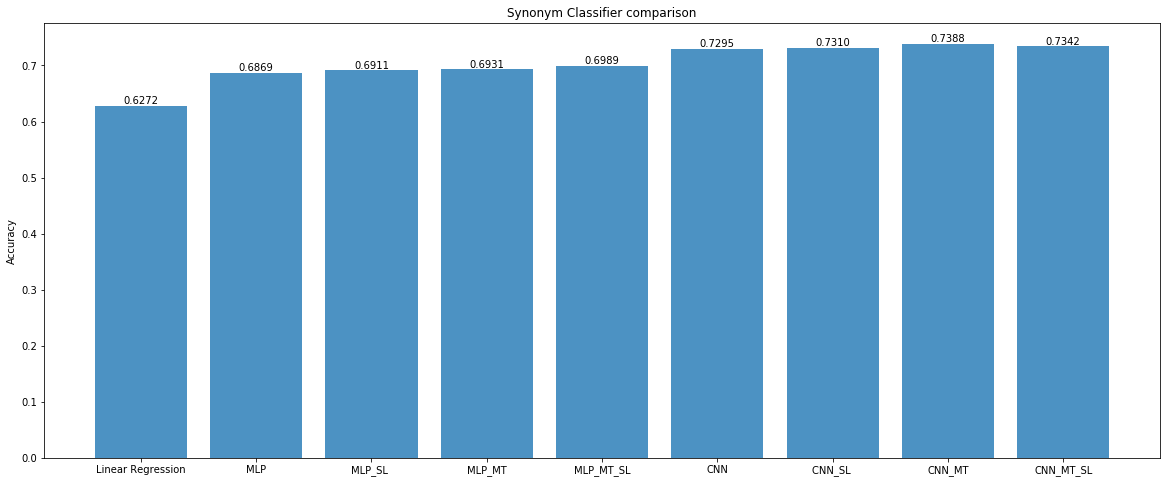

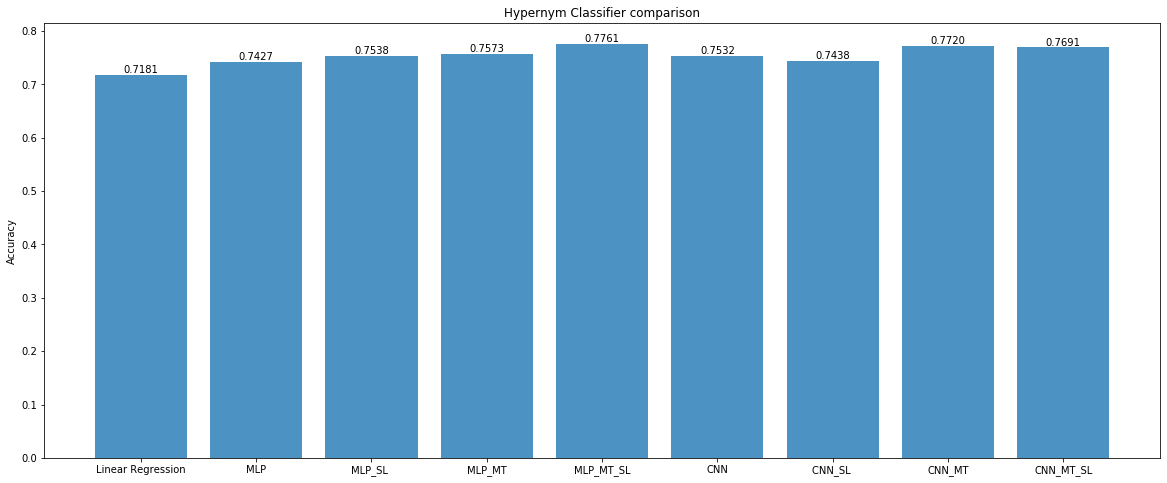

In [30]:
objects = ('Linear Regression', 'MLP', 'MLP_SL ', 'MLP_MT', 'MLP_MT_SL', 'CNN', 'CNN_SL ', 'CNN_MT', 'CNN_MT_SL')
x_pos = np.arange(len(objects)) 
acc = [lr_coord_acc, mlp_coord_acc, mlp_self_learning_coord_acc, mlp_multitask_coord_acc, mlp_multitask_self_learning_coord_acc, cnn_coord_acc,cnn_self_learning_coord_acc, cnn_multitask_coord_acc,cnn_multitask_self_learning_coord_acc]

plt.figure(figsize=(20,8))

plt.bar(x_pos, acc, align = 'center', alpha=0.8)
for clf, res in zip(x_pos, acc):
    plt.text(clf, res, '%.4f'%res, ha='center', va='bottom', fontsize=10)
plt.ylim = (0.5,1)
plt.xticks(x_pos, objects)
plt.ylabel('Accuracy')
plt.title('Synonym Classifier comparison')
plt.show()

acc = [lr_hyper_acc, mlp_hyper_acc, mlp_self_learning_hyper_acc, mlp_multitask_hyper_acc, mlp_multitask_self_learning_hyper_acc, cnn_hyper_acc,cnn_self_learning_hyper_acc, cnn_multitask_hyper_acc,cnn_multitask_self_learning_hyper_acc]

plt.figure(figsize=(20,8))

plt.bar(x_pos, acc, align = 'center', alpha=0.8)
for clf, res in zip(x_pos, acc):
    plt.text(clf, res, '%.4f'%res, ha='center', va='bottom', fontsize=10)

plt.xticks(x_pos, objects)
plt.ylabel('Accuracy')
plt.title('Hypernym Classifier comparison')

plt.show()


The above graphs show the final accuracy of our models. For hypernymy classification, best configuration is combination of MLP NN, with multitask and self learning, where as for the synonymy task, best performance is achieved by combination of CNN, multitask and self learning model.The overall improvement for hypernymy prediction is 1.3 % over the best base line(CNN), whereas for the synonymy task, improvement over the best base line(CNN) is 0.4%. So, these results tend to suggest that hypernymy identification may greatly be impacted by the concurrent learning of synonymy relation and vice versa (although to a less extent).